In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

file_path = 'train2.csv'
df = pd.read_csv(file_path)

df = df.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN']) #불러와서 필요없는 열 삭제

categorical_columns = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# 파생변수 생성

In [3]:
import numpy as np

# 연간 소득 대비 신용카드 수 비율 (Num_Credit_Card가 0인 경우 NaN 방지)
df['Income_per_Credit_Card'] = np.where(df['Num_Credit_Card'] != 0, df['Annual_Income'] / df['Num_Credit_Card'], 0)

# 연간 소득 대비 대출 수 비율 (Num_of_Loan이 0인 경우 NaN 방지)
df['Income_per_Loan'] = np.where(df['Num_of_Loan'] != 0, df['Annual_Income'] / df['Num_of_Loan'], 0)

# 연간 소득 대비 미지급 잔액 비율 (Outstanding_Debt이 0인 경우 NaN 방지)
df['Income_to_Liability_Ratio'] = np.where(df['Outstanding_Debt'] != 0, df['Annual_Income'] / df['Outstanding_Debt'], 0)

# 미지급 잔액 대비 신용카드 한도 변경 비율 (Changed_Credit_Limit이 0인 경우 NaN 방지)
df['Debt_to_Credit_Ratio'] = np.where(df['Changed_Credit_Limit'] != 0, df['Outstanding_Debt'] / df['Changed_Credit_Limit'], 0)

# 신용 이력 기간 대비 은행 계좌 수 (Num_Bank_Accounts가 0인 경우 NaN 방지)
df['Credit_Age_per_Account'] = np.where(df['Num_Bank_Accounts'] != 0, df['Credit_History_Age'] / df['Num_Bank_Accounts'], 0)

# 월별 EMI 납부 금액 대비 월급 비율 (Monthly_Inhand_Salary가 0인 경우 NaN 방지)
df['EMI_to_Income_Ratio'] = np.where(df['Monthly_Inhand_Salary'] != 0, df['Total_EMI_per_month'] / df['Monthly_Inhand_Salary'], 0)

# 대출 수 대비 연체 횟수 비율 (Num_of_Loan이 0인 경우 NaN 방지)
df['Delay_Rate'] = np.where(df['Num_of_Loan'] != 0, df['Num_of_Delayed_Payment'] / df['Num_of_Loan'], 0)

# 연체 일수를 대출 수로 나눈 값 (Num_of_Loan이 0인 경우 NaN 방지)
df['Avg_Delay_Days_per_Loan'] = np.where(df['Num_of_Loan'] != 0, df['Delay_from_due_date'] / df['Num_of_Loan'], 0)

# 월별 투자 금액 대비 연간 소득 비율 (Annual_Income이 0인 경우 NaN 방지)
df['Total_Investment_to_Income_Ratio'] = np.where(df['Annual_Income'] != 0, (df['Amount_invested_monthly'] * 12) / df['Annual_Income'], 0)

# 월별 절약 금액 (월급에서 EMI와 투자 금액을 뺀 값)
df['Net_Savings_per_Month'] = df['Monthly_Inhand_Salary'] - df['Total_EMI_per_month'] - df['Amount_invested_monthly']

## K-means 군집분석

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm  # tqdm 불러오기
import matplotlib.pyplot as plt

# 수치형 데이터만 선택
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df_numerical = df[numerical_columns]

# StandardScaler로 표준화
scaler = StandardScaler()
df_numerical_scaled = scaler.fit_transform(df_numerical)

Calculating silhouette scores: 100%|██████████| 8/8 [09:07<00:00, 68.49s/it]


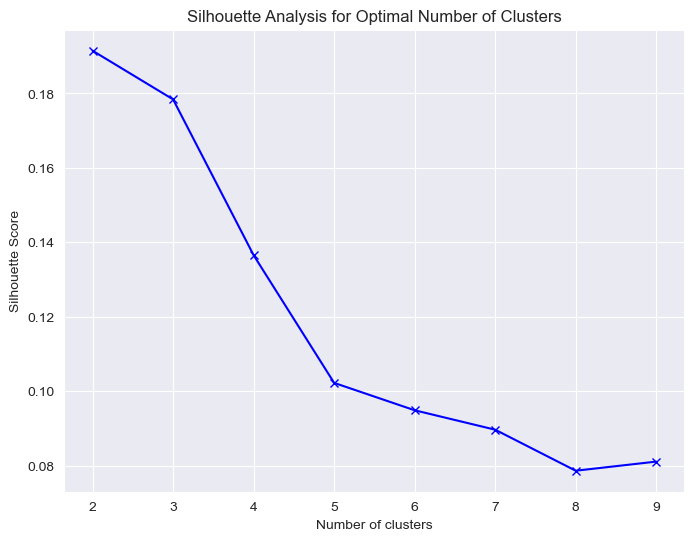

In [5]:
# 실루엣 스코어 계산
silhouette_scores = []

# tqdm을 range에 적용하여 진행 상황 표시
for k in tqdm(range(2, 10), desc="Calculating silhouette scores"):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_numerical_scaled)
    score = silhouette_score(df_numerical_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 실루엣 스코어 시각화
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['kmeans'] = kmeans.fit_predict(df_numerical_scaled)

In [9]:
df.to_csv('scaled_train.csv', index=False)